# Setup (Packages)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

from tqdm.notebook import tqdm

In [2]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(" ", ["red", "yellow", "green"])

In [3]:
np.random.seed(0)

# Generate Data

In [4]:
data, labels = make_blobs(n_samples = 1000, n_features = 2, centers = 4, random_state = 0)
print(data.shape, labels. shape)

(1000, 2) (1000,)


[]

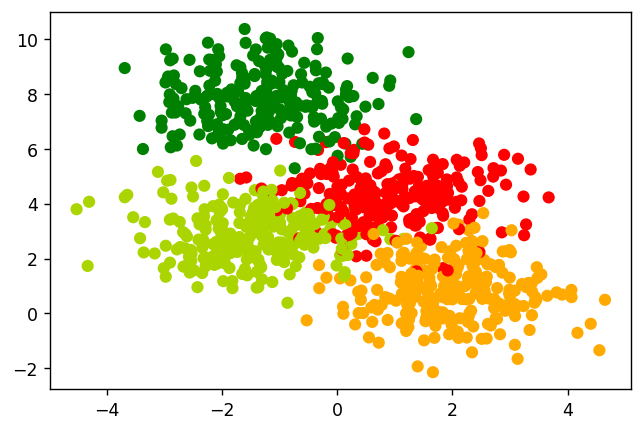

In [5]:
plt.figure(figsize = (6, 4), dpi = 125)
plt.scatter(data[:, 0], data[:, 1], c = labels, cmap = cmap)
plt.plot()

# Multiclass Classification

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify = labels, random_state = 0)
print(X_train.shape, Y_train.shape, X_val.shape)

(750, 2) (750,) (250, 2)


In [7]:
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train, 1)).toarray()
Y_OH_val = enc.fit_transform(np.expand_dims(Y_val, 1)).toarray()

# Feedforward Network

In [8]:
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,4)

In [9]:
class network:
    def __init__(self, W1, W2):

        self.params = {}
        self.params["W1"] = W1.copy()
        self.params["W2"] = W2.copy()
        self.params["B1"] = np.zeros((1, 2))
        self.params["B2"] = np.zeros((1, 4))
        self.gradients = {}
        self.num_layers = 2
        self.update_params = {}
        self.prev_update_params = {}

        for i in range(1, self.num_layers + 1):
            self.update_params["v_w"+str(i)] = 0
            self.update_params["v_b"+str(i)] = 0
            self.update_params["m_w"+str(i)] = 0
            self.update_params["m_b"+str(i)] = 0
            self.prev_update_params["v_w"+str(i)] = 0
            self.prev_update_params["v_b"+str(i)] = 0
    
    def sigmoid(self, X):
        return 1.0 / (1.0 + np.exp(-X))
    
    def softmax(self, X):
        exps = np.exp(X)
        return exps / np.sum(exps, axis = 1).reshape(-1, 1)
    
    def forwardPass(self, X, params = None):
        if params is None: params = self.params

        self.A1 = np.matmul(X, params["W1"]) + params["B1"]            # (N, 2) * (2, 2) -> (N, 2)
        self.H1 = self.sigmoid(self.A1)                                          # (N, 2)
        self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"]      # (N, 2) * (2, 4) -> (N, 4)
        self.H2 = self.softmax(self.A2)                                          # (N, 4)
        return self.H2                                                           # (N, 4)
    
    def backpropagation(self, X, Y, params = None):
        if params is None: params = self.params

        m = X.shape[0]
        self.forwardPass(X, params)

        self.gradients["dA2"] = self.H2 - Y                                                     # (N, 4)
        self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"])                     # (2, N) * (N, 4) -> (2, 4)
        self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis = 0).reshape(1, -1)          # (N, 4) -> (1, 4)
        self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T)                # (N, 4) * (4, 2) -> (N, 2)
        self.gradients["dA1"] = np.multiply(self.gradients["dH1"], (self.H1 * (1 - self.H1)))   # (N, 2) .* (N, 2) -> (N, 2)
        self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"])                           # (2, N) * (N, 4) -> (2, 4)
        self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis = 0).reshape(1, -1)          # (N, 2) -> (1, 2)
    
    def fit(self, X, Y, algo = 'GD', epochs = 1, eta = 1.0, display_loss = True, 
            minibatch_size = 128, gamma = 0.9, eps = 1e-8, beta = 0.9, beta1 = 0.9,
            beta2 = 0.9):
        if display_loss:
            loss = {}
        
        m = X.shape[0]
        for e in tqdm(range(epochs), total = epochs, unit = "epoch"):
            if algo == 'GD':
                self.backpropagation(X, Y)
                for i in range(1, self.num_layers + 1):
                    self.params["W"+str(i)] -= (eta * (self.gradients["dW"+str(i)] / m))
                    self.params["B"+str(i)] -= (eta * (self.gradients["dB"+str(i)] / m))
            
            if algo == 'MiniBatch':
                for k in range(0, m, minibatch_size):
                    self.backpropagation(X[k:k + minibatch_size], Y[k:k + minibatch_size])
                    for i in range(1, self.num_layers + 1):
                        self.params["W"+str(i)] -= (eta * (self.gradients["dW"+str(i)] / minibatch_size))
                        self.params["B"+str(i)] -= (eta * (self.gradients["dB"+str(i)] / minibatch_size))
            
            if algo == 'Momentum':
                self.backpropagation(X, Y)
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] = gamma * self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)] / m)
                    self.update_params["v_b"+str(i)] = gamma * self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)] / m)
                    self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
                    self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]
            
            if algo == "NAG":
                temp_params = {}
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] = gamma * self.prev_update_params["v_w"+str(i)]
                    self.update_params["v_b"+str(i)] = gamma * self.prev_update_params["v_b"+str(i)]
                    
                    temp_params["W"+str(i)] = self.params["W"+str(i)] - self.update_params["v_w"+str(i)]
                    temp_params["B"+str(i)] = self.params["B"+str(i)] - self.update_params["v_b"+str(i)]
                self.backpropagation(X, Y, temp_params)
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] = gamma * self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)] / m)
                    self.update_params["v_b"+str(i)] = gamma * self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)] / m)
                    self.params["W"+str(i)] -= eta * (self.update_params["v_w"+str(i)])
                    self.params["B"+str(i)] -= eta * (self.update_params["v_b"+str(i)])
                self.prev_update_params = self.update_params
            
            if algo == "AdaGrad":
                self.backpropagation(X, Y)
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] += ((self.gradients["dW"+str(i)] / m) ** 2)
                    self.update_params["v_b"+str(i)] += ((self.gradients["dB"+str(i)] / m) ** 2)
                    self.params["W"+str(i)] -= (eta / (np.sqrt(self.update_params["v_w"+str(i)]) + eps)) * (self.gradients["dW"+str(i)] / m)
                    self.params["B"+str(i)] -= (eta / (np.sqrt(self.update_params["v_b"+str(i)]) + eps)) * (self.gradients["dB"+str(i)] / m)
            
            if algo == "RMSProp":
                self.backpropagation(X, Y)
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] = beta * (self.update_params["v_w"+str(i)]) + (1 - beta) * ((self.gradients["dW"+str(i)] / m) ** 2)
                    self.update_params["v_b"+str(i)] = beta * (self.update_params["v_b"+str(i)]) + (1 - beta) * ((self.gradients["dB"+str(i)] / m) ** 2)
                    self.params["W"+str(i)] -= (eta / (np.sqrt(self.update_params["v_w"+str(i)]) + eps)) * (self.gradients["dW"+str(i)] / m)
                    self.params["B"+str(i)] -= (eta / (np.sqrt(self.update_params["v_b"+str(i)]) + eps)) * (self.gradients["dB"+str(i)] / m)
            
            if algo == "Adam":
                self.backpropagation(X, Y)
                num_updates = 0
                for i in range(1, self.num_layers + 1):
                    num_updates += 1
                    self.update_params["m_w"+str(i)] = beta1 * (self.update_params["m_w"+str(i)]) + (1 - beta1) * (self.gradients["dW"+str(i)] / m)
                    self.update_params["v_w"+str(i)] = beta2 * (self.update_params["v_w"+str(i)]) + (1 - beta2) * ((self.gradients["dW"+str(i)] / m) ** 2)
                    m_w_c = self.update_params["m_w"+str(i)] / (1 - np.power(beta1, num_updates))
                    v_w_c = self.update_params["v_w"+str(i)] / (1 - np.power(beta2, num_updates))
                    self.params["W"+str(i)] -= (eta / (np.sqrt(v_w_c + eps))) * m_w_c

                    self.update_params["m_b"+str(i)] = beta1 * (self.update_params["m_b"+str(i)]) + (1 - beta1) * (self.gradients["dB"+str(i)] / m)
                    self.update_params["v_b"+str(i)] = beta2 * (self.update_params["v_b"+str(i)]) + (1 - beta2) * ((self.gradients["dB"+str(i)] / m) ** 2)
                    m_w_c = self.update_params["m_b"+str(i)] / (1 - np.power(beta1, num_updates))
                    v_w_c = self.update_params["v_b"+str(i)] / (1 - np.power(beta2, num_updates))
                    self.params["B"+str(i)] -= (eta / (np.sqrt(v_w_c + eps))) * m_w_c

            if display_loss:
                Y_pred = self.predict(X)
                loss[e] = log_loss(Y, Y_pred)
        
        if display_loss:
            plt.figure(figsize = (6, 4), dpi = 125)
            plt.plot(list(loss.values()), '-o', markersize = 3)
            plt.xlabel('Epochs')
            plt.ylabel('Log Loss')
            plt.show()
    
    def predict(self, X):
        Y_pred = self.forwardPass(X)
        return np.array(Y_pred).squeeze()


In [10]:
def accuracy_summary(display_graph = False):
    Y_pred_train = model.predict(X_train)
    Y_pred_val = model.predict(X_val)

    Y_pred_train = np.argmax(Y_pred_train, 1)
    Y_pred_val = np.argmax(Y_pred_val, 1)

    accuracy_train = accuracy_score(Y_train, Y_pred_train)
    accuracy_val = accuracy_score(Y_val, Y_pred_val)

    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))

    if display_graph:
        plt.figure(figsize = (6, 4), dpi = 125)
        plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
        plt.show()

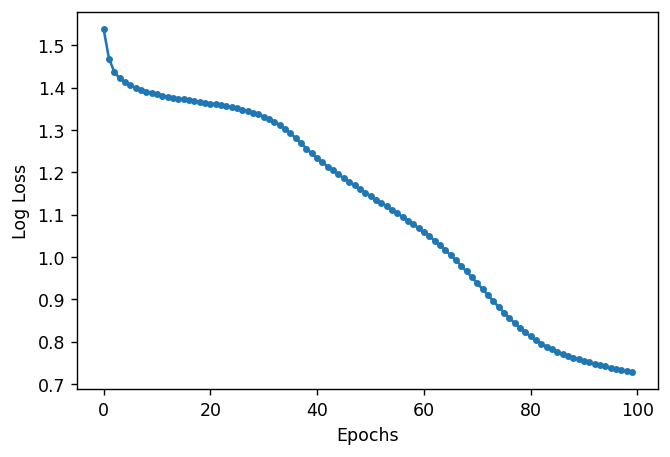

Training accuracy 0.7053
Validation accuracy 0.716
CPU times: user 475 ms, sys: 13.4 ms, total: 488 ms
Wall time: 507 ms


In [11]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, algo = "GD", epochs = 100, eta = 1)
accuracy_summary()

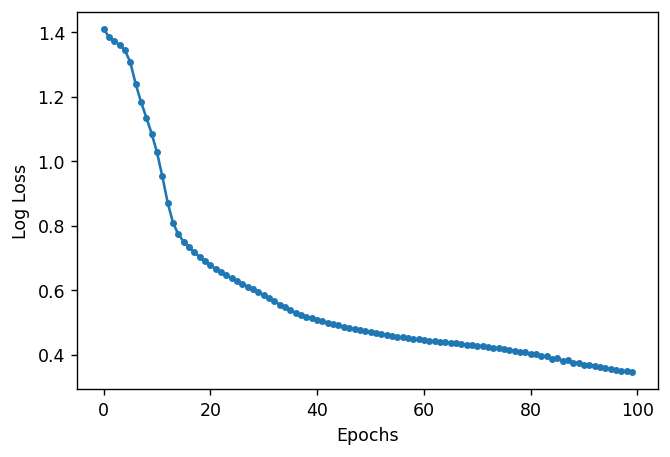

Training accuracy 0.8867
Validation accuracy 0.904
CPU times: user 604 ms, sys: 13.3 ms, total: 617 ms
Wall time: 629 ms


In [12]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, algo = "MiniBatch", epochs = 100, eta = 1, minibatch_size = 128)
accuracy_summary()

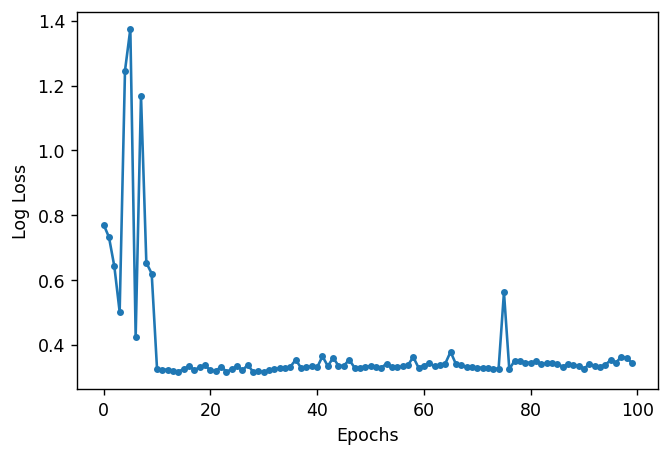

Training accuracy 0.8693
Validation accuracy 0.876
CPU times: user 1.27 s, sys: 29.6 ms, total: 1.3 s
Wall time: 1.33 s


In [13]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, algo = "MiniBatch", epochs = 100, eta = 1, minibatch_size = 8)
accuracy_summary()

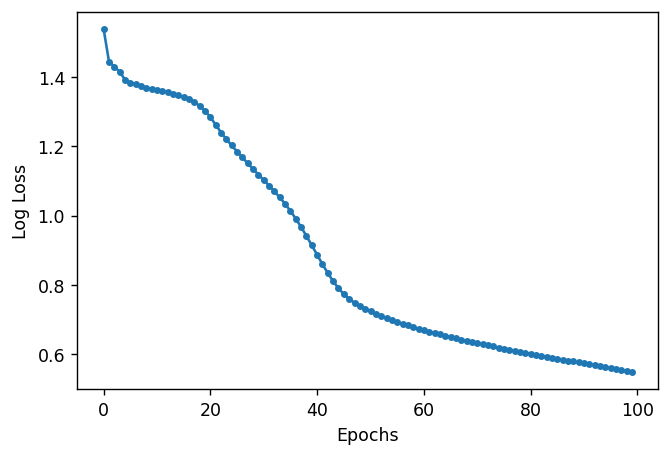

Training accuracy 0.8387
Validation accuracy 0.852
CPU times: user 471 ms, sys: 15.6 ms, total: 486 ms
Wall time: 524 ms


In [14]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, algo = "Momentum", epochs = 100, eta = 1, gamma = 0.5)
accuracy_summary()

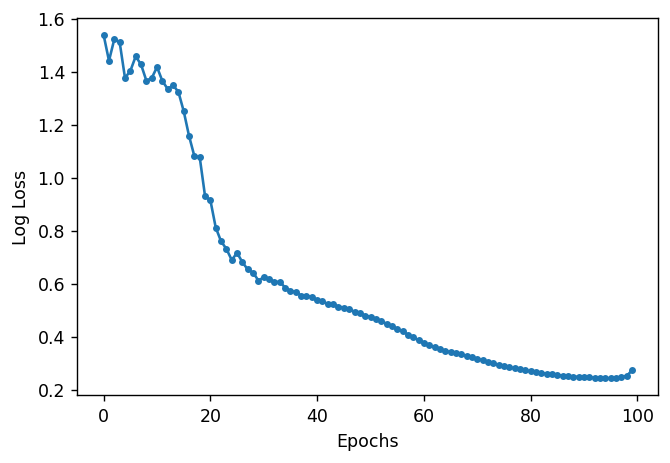

Training accuracy 0.8947
Validation accuracy 0.916
CPU times: user 460 ms, sys: 13.4 ms, total: 473 ms
Wall time: 498 ms


In [15]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, algo = "Momentum", epochs = 100, eta = 1, gamma = 0.9)
accuracy_summary()

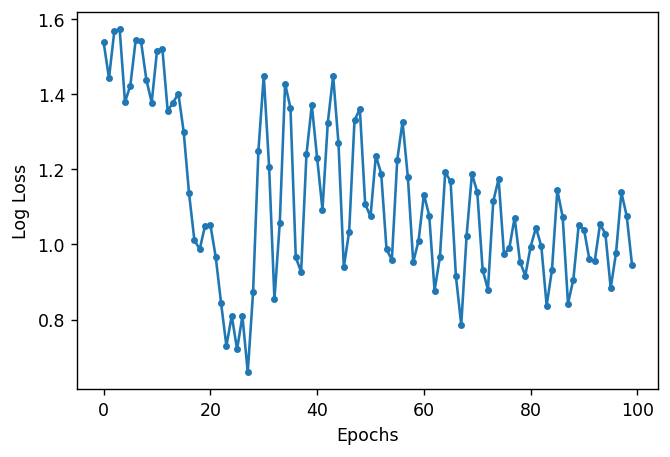

Training accuracy 0.6347
Validation accuracy 0.66
CPU times: user 478 ms, sys: 11.2 ms, total: 489 ms
Wall time: 500 ms


In [16]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, algo = "Momentum", epochs = 100, eta = 1, gamma = 0.99)
accuracy_summary()

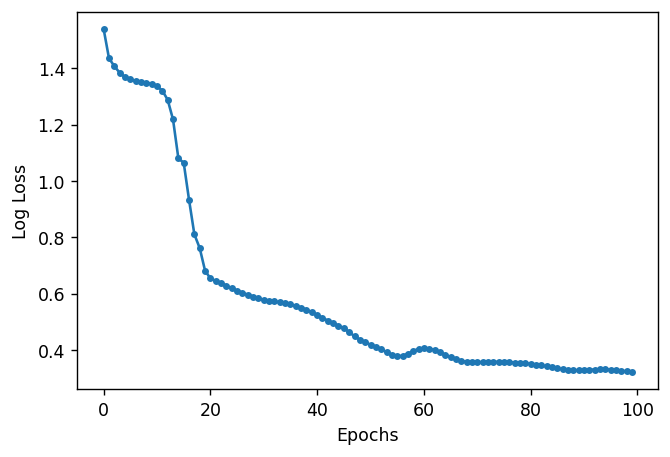

Training accuracy 0.88
Validation accuracy 0.872
CPU times: user 488 ms, sys: 8.78 ms, total: 496 ms
Wall time: 515 ms


In [17]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, algo = "NAG", epochs = 100, eta = 1, gamma = 0.99)
accuracy_summary()

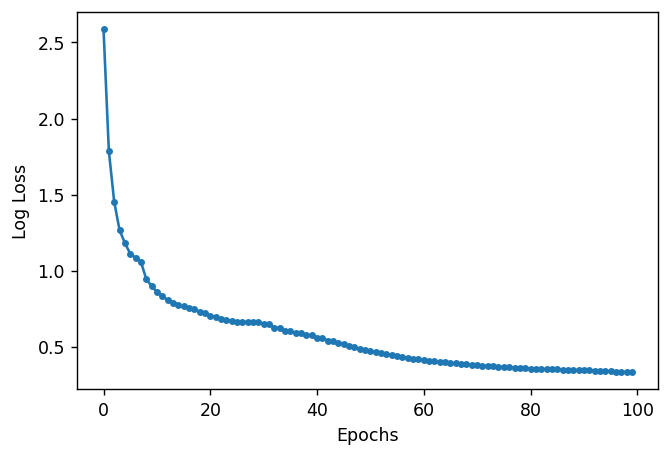

Training accuracy 0.88
Validation accuracy 0.904
CPU times: user 483 ms, sys: 5.67 ms, total: 489 ms
Wall time: 510 ms


In [18]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=1, algo="AdaGrad", display_loss=True)
accuracy_summary()

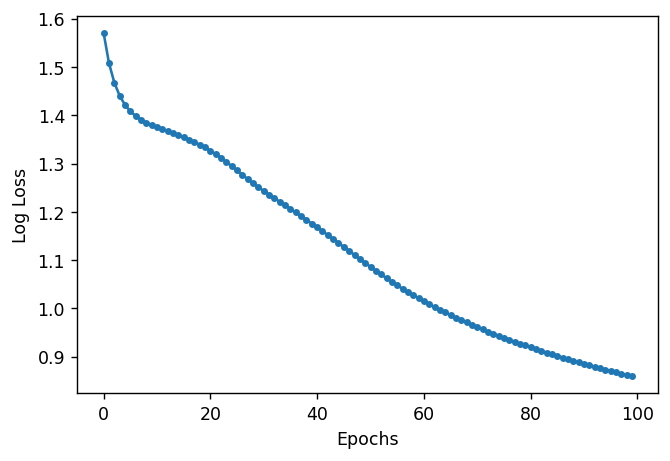

Training accuracy 0.644
Validation accuracy 0.636
CPU times: user 464 ms, sys: 9.12 ms, total: 473 ms
Wall time: 498 ms


In [19]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=.1, algo="AdaGrad", display_loss=True)
accuracy_summary()

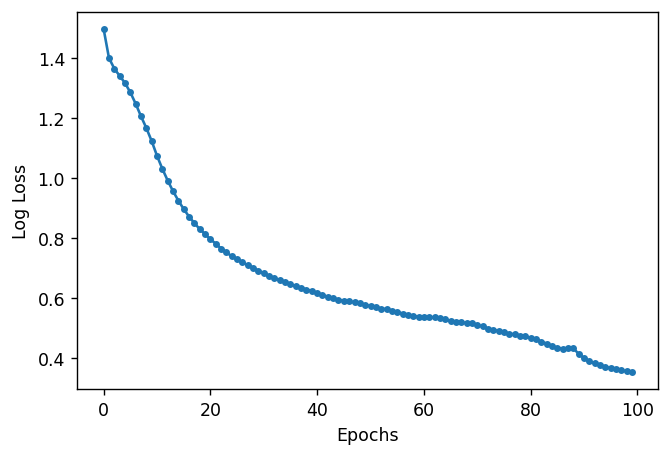

Training accuracy 0.884
Validation accuracy 0.904
CPU times: user 459 ms, sys: 19.4 ms, total: 478 ms
Wall time: 512 ms


In [20]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=.1, algo="RMSProp", beta=0.9, display_loss=True)
accuracy_summary()

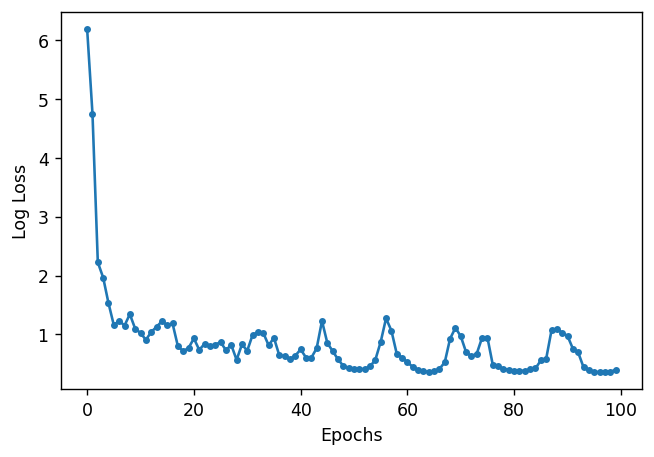

Training accuracy 0.8667
Validation accuracy 0.868
CPU times: user 464 ms, sys: 7.32 ms, total: 472 ms
Wall time: 494 ms


In [21]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=.9, algo="RMSProp", beta=0.9, display_loss=True)
accuracy_summary()

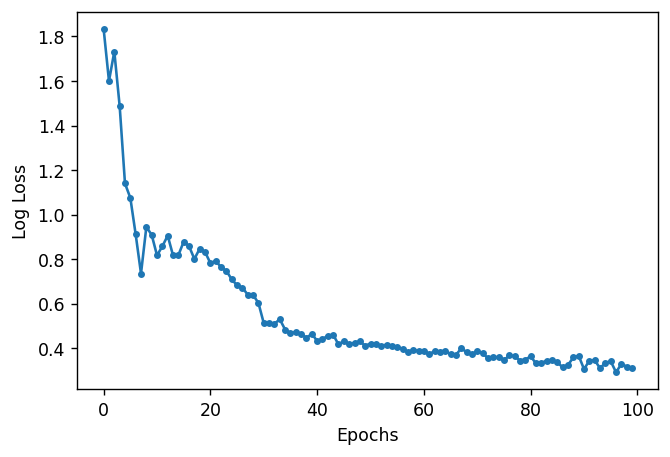

Training accuracy 0.8973
Validation accuracy 0.884
CPU times: user 474 ms, sys: 15.1 ms, total: 489 ms
Wall time: 523 ms


In [22]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=.9, algo="Adam", beta=0.9, display_loss=True)
accuracy_summary()

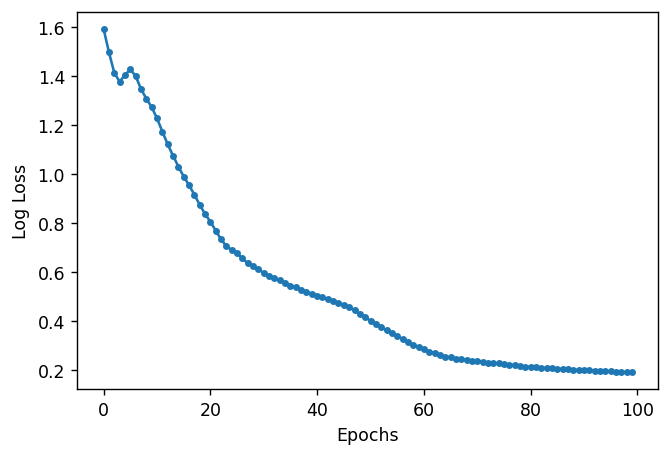

Training accuracy 0.9227
Validation accuracy 0.94


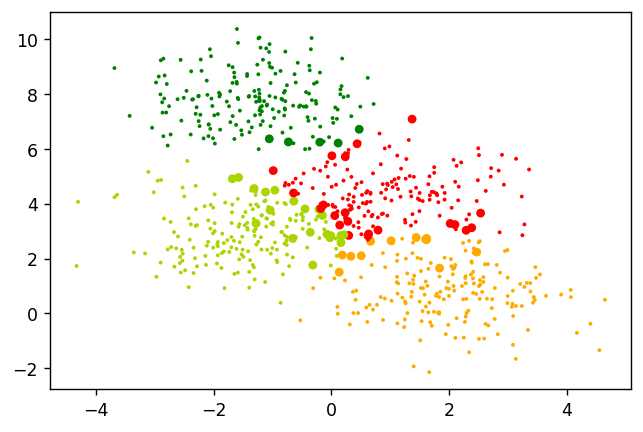

CPU times: user 676 ms, sys: 26 ms, total: 702 ms
Wall time: 718 ms


In [23]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=.1, algo="Adam", beta=0.9, display_loss=True)
accuracy_summary(display_graph = True)

# Good Configuration for Each Algorithm

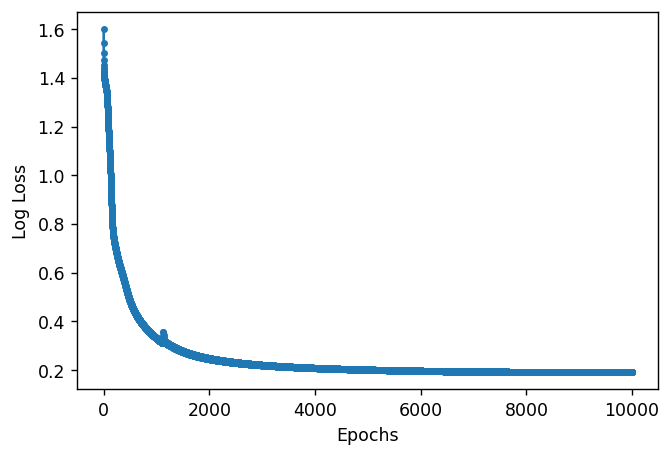

Training accuracy 0.9293
Validation accuracy 0.936
CPU times: user 21.5 s, sys: 191 ms, total: 21.7 s
Wall time: 21.9 s


In [24]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=10000, eta=0.5, algo="GD", display_loss=True)
accuracy_summary()

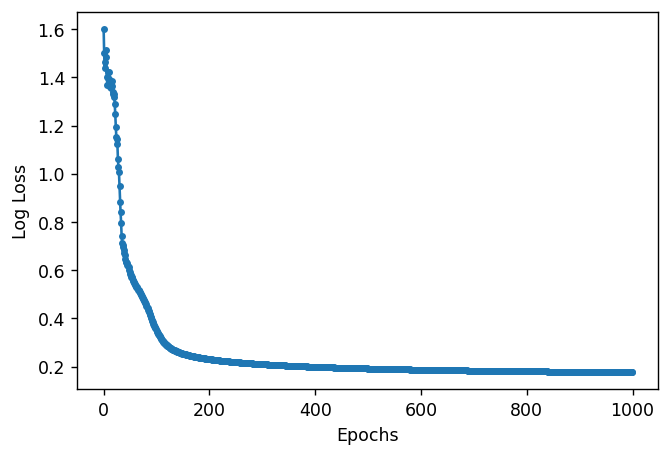

Training accuracy 0.9267
Validation accuracy 0.944
CPU times: user 2.4 s, sys: 18.1 ms, total: 2.42 s
Wall time: 2.48 s


In [25]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=1000, eta=0.5, algo="Momentum", gamma=0.9, display_loss=True)
accuracy_summary()

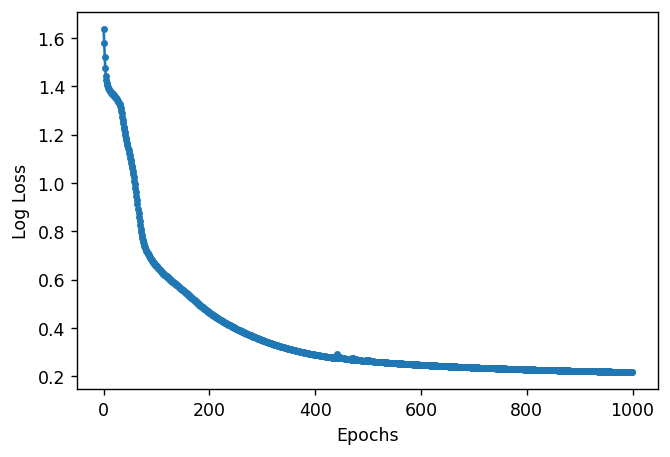

Training accuracy 0.9213
Validation accuracy 0.94
CPU times: user 2.47 s, sys: 28.5 ms, total: 2.5 s
Wall time: 2.53 s


In [26]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=1000, eta=0.5, algo="NAG", gamma=0.9, display_loss=True)
accuracy_summary()

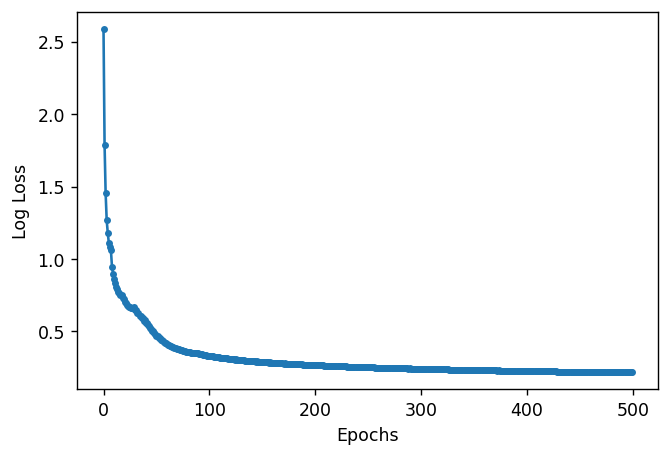

Training accuracy 0.912
Validation accuracy 0.936
CPU times: user 1.35 s, sys: 27.3 ms, total: 1.37 s
Wall time: 1.43 s


In [27]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=500, eta=1, algo="AdaGrad", display_loss=True)
accuracy_summary()

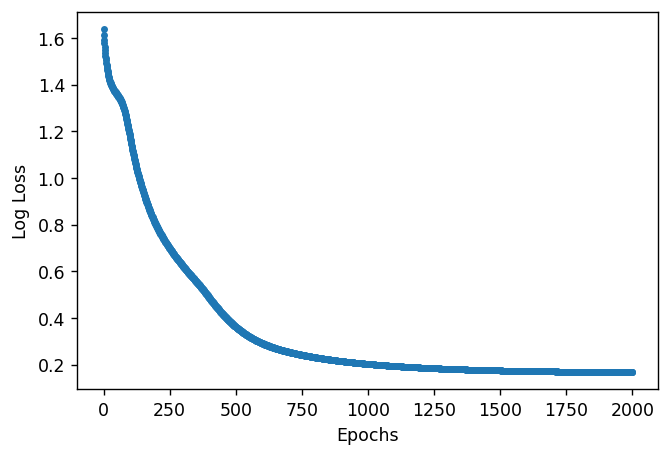

Training accuracy 0.924
Validation accuracy 0.94
CPU times: user 4.74 s, sys: 47.1 ms, total: 4.79 s
Wall time: 4.79 s


In [28]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=2000, eta=.01, algo="RMSProp", beta=0.9, display_loss=True)
accuracy_summary()

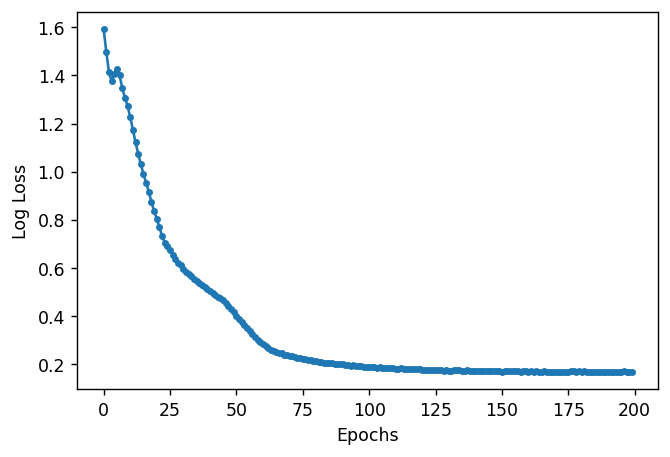

Training accuracy 0.9293
Validation accuracy 0.952
CPU times: user 731 ms, sys: 11.8 ms, total: 743 ms
Wall time: 768 ms


In [29]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=200, eta=.1, algo="Adam", beta=0.9, display_loss=True)
accuracy_summary()